# D(St)reams of Anomalies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

References:
https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection
<br>
Dataset:


In [2]:
df = pd.read_csv("../data/external/rds_cpu_utilization_e47b3b.csv")

In [3]:
df.head()

,timestamp,value
0,2014-04-10 00:02:00,14.012
1,2014-04-10 00:07:00,13.334
2,2014-04-10 00:12:00,15.000
3,2014-04-10 00:17:00,13.998
4,2014-04-10 00:22:00,14.332


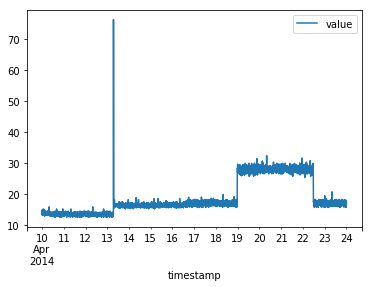

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.plot(x='timestamp', y='value')

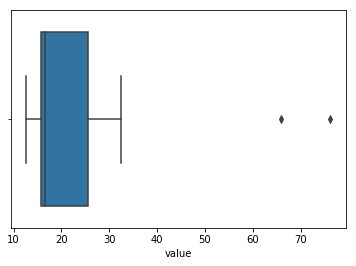

In [5]:
sns.boxplot(x=df['value'])

## Using Isolation Forest to find the anomalies

In [6]:
df1 = df.copy()
df1['hours'] = df1['timestamp'].dt.hour
df1['DayOfTheWeek'] = df1['timestamp'].dt.dayofweek
df1['WeekDay'] = (df1['DayOfTheWeek'] < 5).astype(int)
# time with int to plot easily
df1['time_epoch'] = (df1['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
df1 = df1.drop(columns=['timestamp'])
df1.head()

,value,hours,DayOfTheWeek,WeekDay,time_epoch
0,14.012,0,3,1,13970881
1,13.334,0,3,1,13970884
2,15.000,0,3,1,13970887
3,13.998,0,3,1,13970890
4,14.332,0,3,1,13970893


In [7]:
outliers_fraction = 0.01

data = df1[['value', 'hours', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df1['anomaly'] = pd.Series(model.predict(data))
df1['anomaly'] = df1['anomaly'].map( {1: 0, -1: 1} )
print(df1['anomaly'].value_counts())

0    3991
1      41
Name: anomaly, dtype: int64


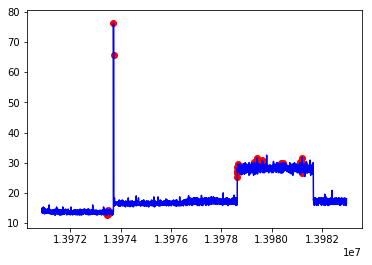

In [8]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df1.loc[df1['anomaly'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df1['time_epoch'], df1['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

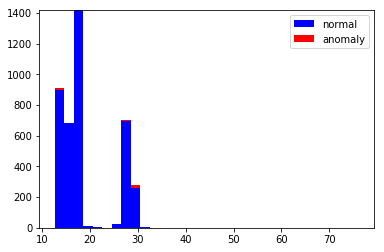

In [9]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df1.loc[df1['anomaly'] == 0, 'value']
b = df1.loc[df1['anomaly'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

## Using One-Class SVM to find the anomalies

In [10]:
data = df1[['value', 'hours', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df1['anomaly2'] = pd.Series(model.predict(data))
df1['anomaly2'] = df1['anomaly2'].map( {1: 0, -1: 1} )
print(df1['anomaly2'].value_counts())

0    3990
1      42
Name: anomaly2, dtype: int64


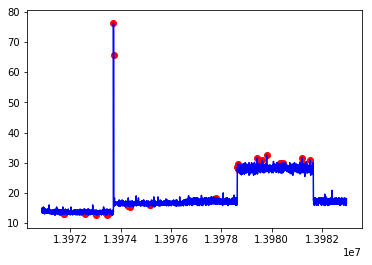

In [11]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df1.loc[df1['anomaly2'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df1['time_epoch'], df1['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

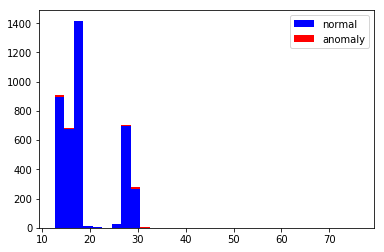

In [12]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df1.loc[df1['anomaly2'] == 0, 'value']
b = df1.loc[df1['anomaly2'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()